# Net Centric Computing CZ3006 Lab 4 - Analysis Traffic log data 

In [1]:
# importing all required Python libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Import the data log 

In [13]:
datafile = "SFlow_Data_lab4.csv"
cols = [
    'type', 'sflow_agent_address', 'input_Port', 'output_Port', 'src_MAC', 
    'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan', 'src_IP', 
    'dest_IP', 'IP_protocol', 'ip_tos', 'ip_ttl', 'src_ip_port', 
    'destination_ip_port', 'tcp_flags', 'packet_size', 'IP_size', 'sampling rate'
]
data = pd.read_csv(datafile) # for testing first
data = data.iloc[:, :20] # retrieve 20 index columns
#cleaning the data
data.columns = cols
data.columns = data.columns.str.upper()
#first 5 values of the log data
data.head()

,TYPE,SFLOW_AGENT_ADDRESS,INPUT_PORT,OUTPUT_PORT,SRC_MAC,DST_MAC,ETHERNET_TYPE,IN_VLAN,OUT_VLAN,SRC_IP,DEST_IP,IP_PROTOCOL,IP_TOS,IP_TTL,SRC_IP_PORT,DESTINATION_IP_PORT,TCP_FLAGS,PACKET_SIZE,IP_SIZE,SAMPLING RATE
0,FLOW,aa.aa.aa.aa,129,193,609c9f851b00,0031466b23cf,0x0800,11.0,919,155.69.160.32,64.233.188.128,6,0x00,56,23159.0,80,0x10,74,52,2048
1,FLOW,aa.aa.aa.aa,137,200,d404ff55fd4d,80711fc76001,0x0800,919.0,280,130.246.176.53,140.115.32.83,6,0x00,50,50041.0,20739,0x10,1518,1500,2048
2,FLOW,aa.aa.aa.aa,129,135,609c9f851b00,002688cd5fc7,0x0800,11.0,919,155.69.160.32,54.169.174.79,17,0x00,120,54241.0,26510,0x10,116,94,2048
3,FLOW,aa.aa.aa.aa,130,199,00239cd087c1,544b8cf9a7df,0x0800,919.0,600,137.132.228.15,193.62.192.8,6,0x00,56,53923.0,34262,0x10,70,52,2048
4,FLOW,aa.aa.aa.aa,129,135,609c9f851b00,002688cd5fc7,0x0800,11.0,919,155.69.160.32,54.255.221.151,17,0x00,120,55069.0,26509,0x10,113,91,2048


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69369 entries, 0 to 69368
Data columns (total 20 columns):
TYPE                   69369 non-null object
SFLOW_AGENT_ADDRESS    69369 non-null object
INPUT_PORT             69369 non-null int64
OUTPUT_PORT            69369 non-null int64
SRC_MAC                69369 non-null object
DST_MAC                69369 non-null object
ETHERNET_TYPE          69369 non-null object
IN_VLAN                69369 non-null float64
OUT_VLAN               69369 non-null int64
SRC_IP                 69369 non-null object
DEST_IP                69369 non-null object
IP_PROTOCOL            69369 non-null int64
IP_TOS                 69369 non-null object
IP_TTL                 69369 non-null int64
SRC_IP_PORT            69369 non-null float64
DESTINATION_IP_PORT    69369 non-null int64
TCP_FLAGS              69369 non-null object
PACKET_SIZE            69369 non-null int64
IP_SIZE                69369 non-null int64
SAMPLING RATE          69369 non-null int6

# Lab 4 exercises

### Function to reorder records base on its appearance times

In [4]:
import json, requests
api_key = "b97929392d4d4885a7ce59e0c9a82985"
# this function use the geolocation API for retrieving the organization information w.r.t an ip address
# at the time when the author code, the api_ket is worked, however, it might not worked the time being reviewed, the API key should be change to be able to successfully viewed the organization w.r.t an ip
def retrieve_organization(ip):
    api_endpoint = "https://api.ipgeolocation.io/ipgeo?apiKey=" + api_key + "&ip=" + ip
    response = requests.get(api_endpoint)
    return response.json()["organization"]
# retrieve top 5 talkers | listeners together with its binding organization
def reorder(column):
    extracted = data[column].value_counts().head()
    extracted = extracted.reset_index()
    extracted.columns = [column, "Count"]
    # append the Organization column in case the column need analysis is Source IP or Destination IP 
    if (column in ["SRC_IP", "DEST_IP"]):
        organization = [retrieve_organization(ip) for ip in extracted[column]]
        extracted["Organization"] = pd.DataFrame(organization)
    return extracted

## Exercise 4A: Top Talkers and Listeners

In [5]:
# top five talkers 
reorder("SRC_IP")

,SRC_IP,Count,Organization
0,193.62.192.8,3041,Jisc Services Limited
1,155.69.160.32,2975,Nanyang Technological University
2,130.14.250.11,2604,National Library of Medicine
3,14.139.196.58,2452,National Knowledge Network
4,140.112.8.139,2056,National Taiwan University


In [6]:
# top five listeners
reorder("DEST_IP").head()

,DEST_IP,Count,Organization
0,103.37.198.100,3841,A*STAR
1,137.132.228.15,3715,National University of Singapore
2,202.21.159.244,2446,"Republic Polytechnic, Singapore"
3,192.101.107.153,2368,ESnet
4,103.21.126.2,2056,Indian Institute of Technology Bombay


## Exercise 4B: Transport Protocol

### - **TCP : 6**

### - **UDP : 17**

In [7]:
ip_protocols = data["IP_PROTOCOL"].value_counts()
# extracted number of TCP and UDP count
tcp = ip_protocols[6]
udp = ip_protocols[17]
# udp and TCP numbers
print("As observed, there are {} packets which correspond to TCP protocols and {} packets which correspond to UDP protocols out of total {} packets".format(tcp, udp, len(data)))
# top five ip_protocols
ip_protocols.head(5)

As observed, there are 56063 packets which correspond to TCP protocols and 9462 packets which correspond to UDP protocols out of total 69369 packets


6     56063
17     9462
50     1698
0      1261
47      657
Name: IP_PROTOCOL, dtype: int64

In [8]:
udp_tcp_percentage = pd.DataFrame([tcp * 100 / len(data), udp * 100 / len(data)], index = ["TCP", "UDP"], columns = ["Percentage"])
udp_tcp_percentage

,Percentage
TCP,80.818521
UDP,13.640099


## Exercise 4C: Application Protocol
- Port numbers define application service requested

In [9]:
reorder("DESTINATION_IP_PORT").head()

,DESTINATION_IP_PORT,Count
0,443,13423
1,80,2647
2,52866,2068
3,45512,1356
4,56152,1341


- **443**: HyperText Transfer Protocol Secure (HTTPS)


- **80**: HyperText Transfer Protocol (HTTP) 


- **52866, 45512, 56152**: Private ports.

## Exercise 4D: Traffic Intensity

- Using the packet sizes of all packers , can calculate the total traffic intensity  

In [10]:
packet_size = data["IP_SIZE"]

count = len(packet_size)
total = round(sum(packet_size) / 1000, 2) # convert to MegaByte

print("Total data for {} packets is: {} MBs".format(count, total))

Total data for 69369 packets is: 64776.32 MBs


## Exercise 4E: Top 5 Communication Pair

In [11]:
# sort in descending order
ex4E = data.groupby(["SRC_IP", "DEST_IP"]).size().sort_values(ascending = False).to_frame().head()
ex4E.columns = ["COUNT"]
ex4E

,,COUNT
SRC_IP,DEST_IP,
193.62.192.8,137.132.228.15,3041
130.14.250.11,103.37.198.100,2599
14.139.196.58,192.101.107.153,2368
140.112.8.139,103.21.126.2,2056
137.132.228.15,193.62.192.8,1910


## Exercise 4F: Visualizing Communication between 

## different IP hosts for top 5 pair

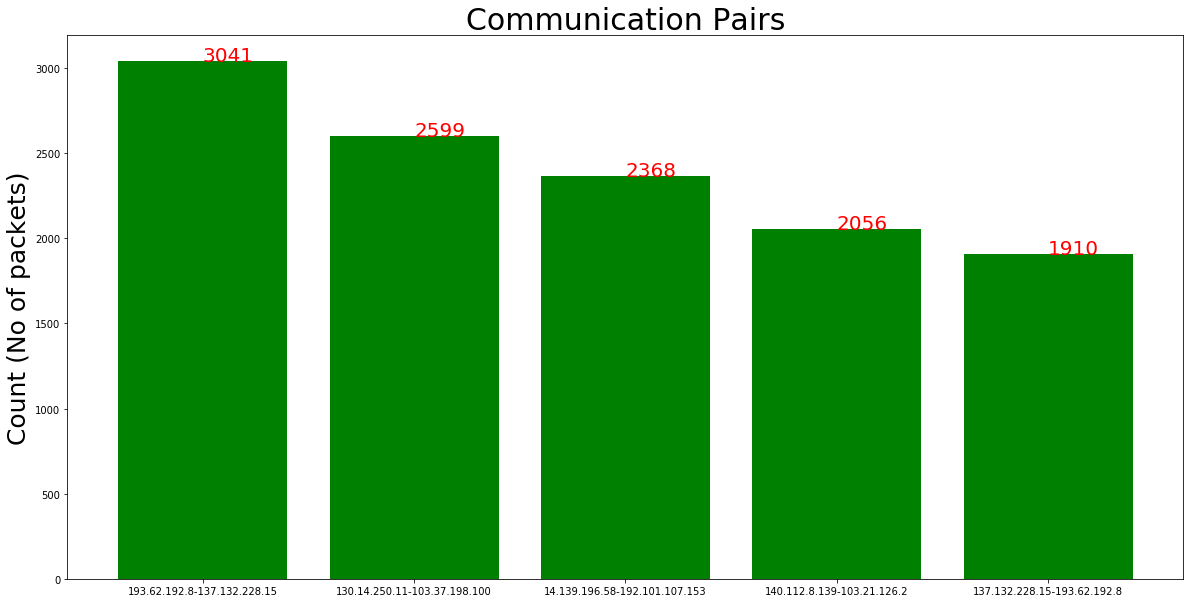

In [12]:
row = [i[0] + "-" + i[1] for i in ex4E.index] 
f,axes = plt.subplots(1, 1, figsize = (20, 10))
plt.bar(row, ex4E["COUNT"], align = "center", color = "g")
plt.ylabel("Count (No of packets)", fontsize = 25)
plt.title("Communication Pairs", fontsize = 30)
for i, v in enumerate(ex4E["COUNT"]):
    axes.text(i, v + 0.5, str(v),color = "red", fontsize = 20)
plt.show()